# Preload libraries and functions
First of all, let's import libraries that will be used in this example

In [108]:
# clear all variants
# %reset -f   

# Autoreload the customize modules.
%reload_ext autoreload
# Or load_ext autoreload for the first run
# %aimport
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time, os


# import tensorflow as tf
# from tensorflow import keras

import HackModules.HackClasses as hc
import HackModules.HackFunctions as hf
from HackModules.progressMonitor import progressBar
from HackModules.progressMonitor import timer

#matplot inline
# np.set_printoptions(precision=8)

# help(hc) # To test the docstrings ((TBDBS To be deleted before submission))

# Alternative customize module import method
# import sys, os
# sys.path.append(os.getcwd()+'/HackModules/') # add /HackModules to the path
# import HackClasses as hc


Define some seldom used functions and class

# Data Import and Initialization

In [84]:
df = pd.read_excel('obs_data_w.xlsx', sheet_name=0) #sheet_name='Sheet1')
print(df)

         V    T  uncertainty             J
0     0.00  100     0.001000  0.000000e+00
1     0.05  100     0.001000  6.417136e-90
2     0.10  100     0.001000  1.081096e-88
3     0.15  100     0.001000  1.719633e-87
4     0.20  100     0.001000  2.725747e-86
5     0.25  100     0.001000  4.319561e-85
6     0.30  100     0.001000  6.845225e-84
7     0.35  100     0.001000  1.084764e-82
8     0.40  100     0.001000  1.719028e-81
9     0.45  100     0.001000  2.724148e-80
10    0.50  100     0.001000  4.316963e-79
11    0.55  100     0.001000  6.841100e-78
12    0.60  100     0.001000  1.084111e-76
13    0.65  100     0.001000  1.717992e-75
14    0.70  100     0.001000  2.722506e-74
15    0.75  100     0.001000  4.314361e-73
16    0.80  100     0.001000  6.836977e-72
17    0.85  100     0.001000  1.083457e-70
18    0.90  100     0.001000  1.716957e-69
19    0.95  100     0.001000  2.720865e-68
20    1.00  100     0.001000  4.311761e-67
21    1.05  100     0.001000  6.832857e-66
22    1.10 

## Train, cross validation and test data

### Random Method 1: Sample function of df

In [102]:
tcv=df.sample(frac=0.8 ,random_state=8989)
test=df.drop(tcv.index)
test=test.sample(frac=1) # shuffle the rows

print(test.shape)

(1579, 4)


### Random Method 2: random array

In [ ]:
# idx=np.arange(0,len(df))
# np.random.shuffle(idx)
# temp_split=math.floor(0.8*len(df))
# #idx[0:20]
# train=df.iloc[idx[0:temp_split],:]
# test=df.iloc[idx[temp_split:],:] # Output all the elements after temp_split
# print(train.shape)
# print(test.shape)

## Split test data into data and results, add polynominal features and normalize them.

In [104]:
test_data=test.loc[:,['V','T']]
test_unc=test.uncertainty.values
test_J=test.J.values

degree = 2
test_data=hc.data(test_data,degree=degree,method='std')

print(f'The polynominal degree is {degree}.\n')
print('Polynominal test data = \n', test_data.poly, '\n')
print('Normalized test_data = \n', test_data.norm, '\n')

The polynominal degree is 2.

Polynominal test data = 
 [[5.50000e-01 1.01000e+02 3.02500e-01 5.55500e+01 1.02010e+04]
 [1.80000e+00 1.50000e+02 3.24000e+00 2.70000e+02 2.25000e+04]
 [3.55000e+00 1.25000e+02 1.26025e+01 4.43750e+02 1.56250e+04]
 ...
 [3.25000e+00 1.00000e+02 1.05625e+01 3.25000e+02 1.00000e+04]
 [1.65000e+00 1.73000e+02 2.72250e+00 2.85450e+02 2.99290e+04]
 [1.70000e+00 1.93000e+02 2.89000e+00 3.28100e+02 3.72490e+04]] 

Normalized test_data = 
 [[ 1.         -1.04888668 -0.66641464 -0.9311726  -1.19278185 -0.44371734]
 [ 1.          0.14691987 -0.30581678 -0.14985314 -0.03834084 -0.32233001]
 [ 1.          1.82104904 -0.48979528  2.34039483  0.89700131 -0.39018414]
 ...
 [ 1.          1.53405547 -0.67377378  1.7977934   0.25773869 -0.44570114]
 [ 1.          0.00342308 -0.13655656 -0.28749835  0.04483059 -0.24900808]
 [ 1.          0.05125534  0.01062624 -0.24294652  0.27442681 -0.17676195]] 



# Model Training

## Method 1: Normal Equation
Training with regulation

### Find the best polynomial degree

Progress: |██████████████████████████████████████████████████| 100.00% Complete     Run: 00:00:51; Left: 00:00:00 (Total: 00:00:51)

The time cost is 00:00:51
The parameters are:
	degree = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
	beta = 0
	epoch= {epoch}
	multiprcess is {multiprocess}
[4. 4. 4. 4. 3.]
The value of degree should be  4


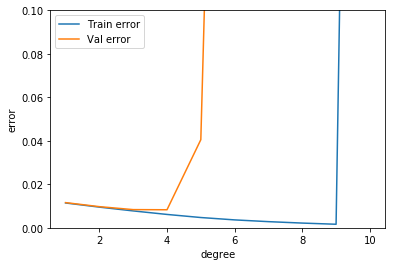

In [141]:
degree_range=list(range(1,11))
train_num=5
epoch   =100
multiprocess = 'OFF'
cpu_num=4
beta=0

# Calculate the beta array
t_start=time.time()
degree_array, error_train_poly, error_cv_poly=hf.train_loop(tcv, train_num, epoch, degree_range, other_v=beta, 
                                n_v='degree', rep=True, multiprocess=multiprocess, cpu_num=cpu_num, show=True)
t_end=time.time()
print(f'\nThe time cost is {hf.formatTime(t_end-t_start)}',end='\n')

print(f'The parameters are:\n\tdegree = {degree_range}\n\tbeta = {beta}'+
      '\n\tepoch= {epoch}\n\tmultiprcess is {multiprocess}')

d_idx=error_cv_poly.argmin()
degree_best = degree_range[d_idx]
print(degree_array)
print('The value of degree should be ', degree_best)
# print('The test error with best THETA and BETA is ', error_test_reg)

# plot error vs. beta
plt.figure()
plt.plot(degree_range, error_train_poly, label = 'Train error')
plt.plot(degree_range, error_cv_poly, label = 'Val error')
plt.ylim((0,0.1))
plt.xlabel('degree')
plt.ylabel('error')
plt.legend()

### Example to find best regulation coefficient

In [144]:
beta_range=np.geomspace(0.001,25, num = 50-1, endpoint = True, dtype=np.float64)
beta_range=np.insert(beta_range,0,0) # insert a zero element in the first index
beta_num=5
epoch   =1000
multiprocess = 'ON'
cpu_num=4
degree =4

# Calculate the beta array, the other_v is degree
t_start=time.time()
beta_array, error_train_reg, error_cv_reg=hf.train_loop(tcv, beta_num, epoch, beta_range, other_v=degree, 
                            n_v='beta', rep=True, multiprocess=multiprocess, cpu_num=cpu_num)
t_end=time.time()
print(f'\nThe time cost is {hf.formatTime(t_end-t_start)}',end='\n')

print(f'The parameters are:\n\tbeta_num = {beta_num}\n\tdegree={degree}\n\tepoch = {epoch}\n\tmultiprcess is {multiprocess}')
print(f'The values of beta with various regulation coefficients and '+ 
      f'different training samples are:\n{beta_array}')

b_idx=error_cv_reg.argmin()
beta_best = degree_range[b_idx]
print('The value of BETA should be ', beta_best)
# print('The test error with best THETA and BETA is ', error_test_reg)

# log-scale plot error vs. beta
plt.figure()
plt.semilogx(beta_range, error_train_reg, label = 'Train error')
plt.semilogx(beta_range, error_cv_reg, label = 'Val error')
plt.xlabel('regulization coefficient (beta)')
plt.ylabel('error')
plt.legend()

# plot error vs. beta
plt.figure()
plt.plot(beta_range, error_train_reg, label = 'Train error')
plt.plot(beta_range, error_cv_reg, label = 'Val error')
plt.xlabel('regulization coefficient (beta)')
plt.ylabel('error')
plt.legend()

Process ForkPoolWorker-6731:
Process ForkPoolWorker-6730:
Process ForkPoolWorker-6729:
Process ForkPoolWorker-6732:
Traceback (most recent call last):


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/Users/wandy/anaconda3/envs/NUSworkshop/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/wandy/anaconda3/envs/NUSworkshop/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/wandy/anaconda3/envs/NUSworkshop/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/wandy/anaconda3/envs/NUSworkshop/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/wandy/anaconda3/envs/NUSworkshop/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/wandy/OneDrive/My Projects/AI for materials/Challenge/Hackathon/HackModules/HackFunctions.py", line 60, in train_model
    train_data=hc.data(train.loc[:,['V','T']], degree=degree, method ='std')
  File "/Users/wandy/anaconda3/envs/NUS

In [ ]:
degree_range=list(range(1,15))

# Prediction

In [50]:
beta_array.mean()

1.5102402949001281

In [80]:
len(beta_range)

50

In [30]:
print(f'The paramters are:\nbeta_num = {beta_num}\nepoch = {epoch}')

NameError: name 'beta_num' is not defined

In [ ]:
t.polyFeature(2)
t.array.shape

In [ ]:
type(theta_reg)

In [54]:
list(range(1,5))

[1, 2, 3, 4]

In [18]:
os.cpu_count()

64